# Add
* u-g,g-r,r-i,i-z만 사용
* category_features 사용위해 lgb.train사용
* 제출결과 : 0.4161080142

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss
import lightgbm as lgb

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# #colab용
# import os
# os.chdir('/content/drive/My Drive/Colab Notebooks/Dacon/천체관측/')

In [4]:
# path = "/content/drive/My Drive/Colab Notebooks/Dacon/천체관측/data/" #colab
path = "./data/" #local
train_df = pd.read_csv(path+'train.csv',index_col=0)
test_df = pd.read_csv(path+'test.csv',index_col=0)
sample_submission_df = pd.read_csv(path+'sample_submission.csv',index_col=0)
pd.options.display.max_columns = 30

In [5]:
(train_df['psfMag_u']/train_df['fiberMag_u']).mean()

0.9917386947983355

In [6]:
(train_df['psfMag_r']/train_df['fiberMag_r']).mean()

0.9883497404198113

In [7]:
train_df[['psfMag_u','fiberMag_u','petroMag_u']]

,psfMag_u,fiberMag_u,petroMag_u
id,,,
0,23.198224,22.581309,22.504317
1,21.431355,21.868797,21.360701
2,17.851451,18.171890,17.867253
3,20.789900,21.039030,20.433907
4,26.454969,25.700632,25.859229
5,19.781358,20.167919,19.982358
6,22.227121,22.765383,21.954245
7,17.024278,17.336320,17.093958
8,20.793464,21.183702,21.121991


In [8]:
train_cols = list(train_df.columns)
test_cols = list(test_df.columns)
train_cols.remove('fiberID')
test_cols.remove('fiberID')

## DATA Setting

In [9]:
column_number = {}
number_columns = {}
for i, column in enumerate(sample_submission_df.columns):
    column_number[column] = i
    number_columns[i] = column
    
    
def to_number(x, dic):
    return dic[x]

train_df['type_num'] = train_df['type'].apply(lambda x: to_number(x, column_number))


In [10]:
def add_minus_feature_all(data,test = False):
    '''
    combination으로 모든 변수들의 조합에 대해서 컬럼생성 
    각 mag에서 가장 높은값의 filter를 받아오는 "~~mag_MAX"생성
    결과 64개로 증가
    '''
    from itertools import combinations
    n = 0
    for count in range(5,21,5):
        s = 2
        if test == True :
            s = 1
        selected = data.columns[s:].values[n:count]
        mag = str.split(selected[0],'_')[0]
        data[mag+"_MAX"] = data[selected].apply(lambda x : str.split(np.argmax(x),'_')[1],axis = 1)
        for combi in list(combinations(selected,2)):
            name_1st = str.split(combi[0],'_')[1]
            name_2nd = str.split(combi[1],'_')[1]
            data[mag+"_"+name_1st+"-"+name_2nd] = data[combi[0]]-data[combi[1]]
        n=count
    return data

In [11]:
def add_minus_feature(data,test = False):
    '''
    근접변수에 대해서만 컬럼생성 ex) 'fiberMag_u-g', 'fiberMag_g-r', 'fiberMag_r-i', 'fiberMag_i-z'
    각 mag에서 가장 높은값의 filter를 받아오는 "~~mag_MAX"생성
    결과 38개로 증가 
    '''
    from itertools import combinations
    n = 0
    m = 0
    for count in range(5,21,5):
        s = 2
        if test == True :
            s = 1
        selected = data.columns[s:].values[n:count]
        mag = str.split(selected[0],'_')[0]
        data[mag+"_MAX"] = data[selected].apply(lambda x : str.split(np.argmax(x),'_')[1],axis = 1)
        for i in range(0,len(selected)):        
            if i>0: 
                name_1st = str.split(m,'_')[1]
                name_2nd = str.split(selected[i],'_')[1]
                data[mag+"_"+name_1st+"-"+name_2nd] = data[m]-data[selected[i]]
            m = selected[i]    
        n=count
    return data

In [12]:
train_df = add_minus_feature(train_df)
test_df = add_minus_feature(test_df,True)

C:\Users\starl\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:61: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  return bound(*args, **kwds)


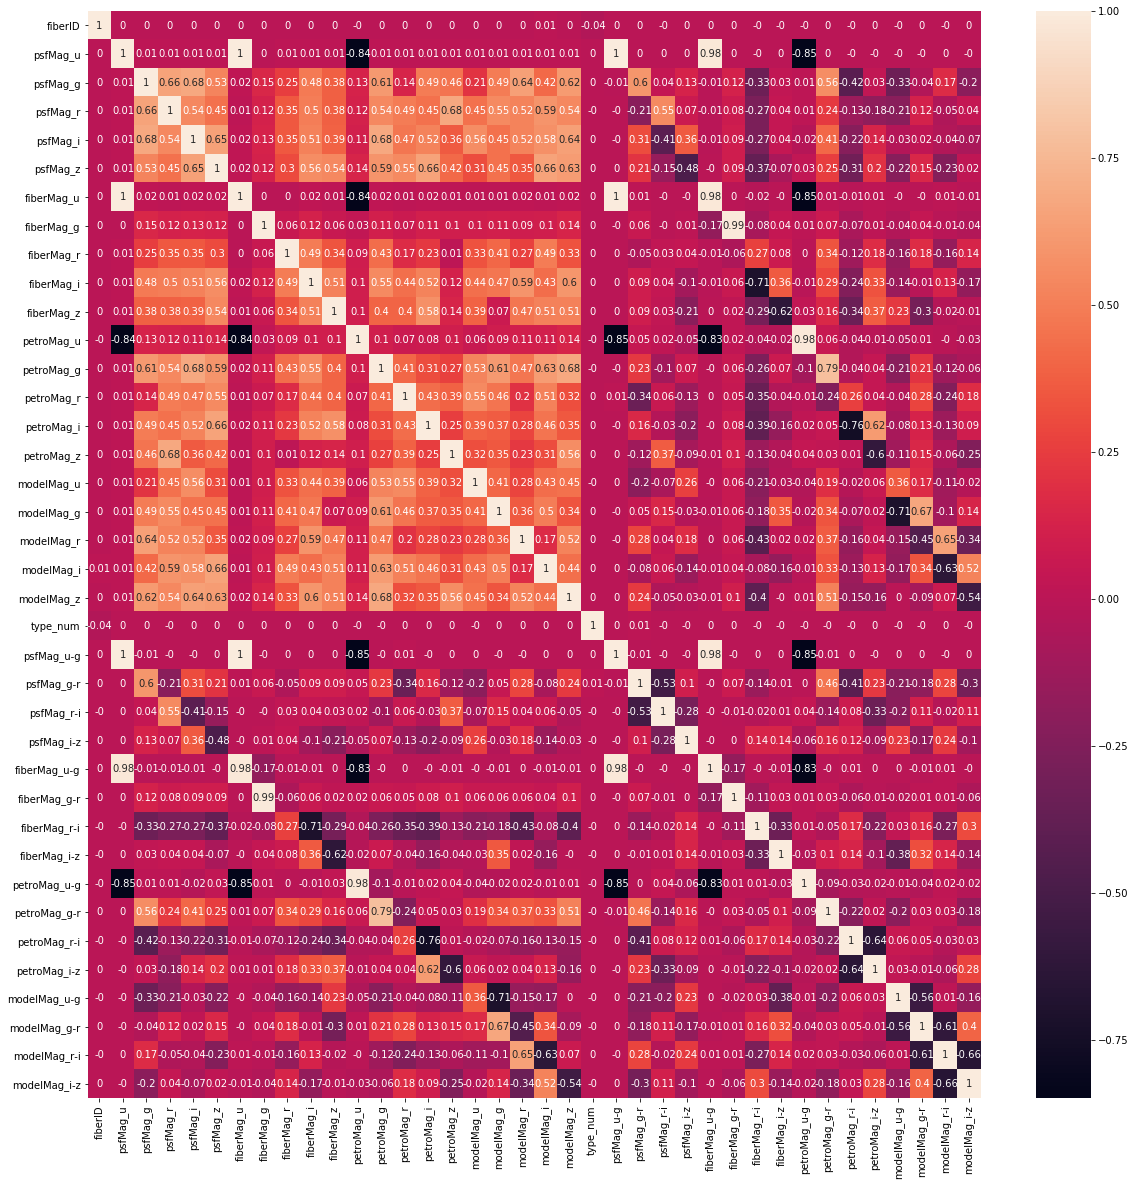

In [13]:
plt.figure(figsize =(20,20))
sns.heatmap(train_df.corr().applymap(lambda x :round(x,2)),annot = True)

In [14]:
def label_encode(data):
    '''
    각 mag에서 가장 높은값의 filter를 labelencoding 
    '''
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    taget_cols = ['psfMag_MAX','fiberMag_MAX','petroMag_MAX','modelMag_MAX']
    for col in taget_cols:
        data[col] = le.fit_transform(data[col])
    return data

In [15]:
train_df = label_encode(train_df)
test_df = label_encode(test_df)

In [16]:
train_cols

['type',
 'psfMag_u',
 'psfMag_g',
 'psfMag_r',
 'psfMag_i',
 'psfMag_z',
 'fiberMag_u',
 'fiberMag_g',
 'fiberMag_r',
 'fiberMag_i',
 'fiberMag_z',
 'petroMag_u',
 'petroMag_g',
 'petroMag_r',
 'petroMag_i',
 'petroMag_z',
 'modelMag_u',
 'modelMag_g',
 'modelMag_r',
 'modelMag_i',
 'modelMag_z']

In [17]:
train_X = train_df.drop(columns=train_cols, axis=1)

In [18]:
train_X = train_df.drop(columns=train_cols, axis=1)
train_X = train_X.drop(columns="type_num", axis=1)
train_y = train_df['type_num']
test_X = test_df.drop(columns=test_cols, axis=1)

In [19]:
train_X.columns

Index(['fiberID', 'psfMag_MAX', 'psfMag_u-g', 'psfMag_g-r', 'psfMag_r-i',
       'psfMag_i-z', 'fiberMag_MAX', 'fiberMag_u-g', 'fiberMag_g-r',
       'fiberMag_r-i', 'fiberMag_i-z', 'petroMag_MAX', 'petroMag_u-g',
       'petroMag_g-r', 'petroMag_r-i', 'petroMag_i-z', 'modelMag_MAX',
       'modelMag_u-g', 'modelMag_g-r', 'modelMag_r-i', 'modelMag_i-z'],
      dtype='object')

In [20]:
train_X.shape, test_X.shape

((199991, 21), (10009, 21))

In [21]:
X_train, X_test, y_train, y_test = train_test_split(train_X, train_y, test_size=0.3, random_state=42,stratify = train_y)

In [26]:
train_ds = lgb.Dataset(X_train, label = y_train, categorical_feature=['fiberID'])
test_ds = lgb.Dataset(X_test, label = y_test, categorical_feature=['fiberID']) 

In [27]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'num_class': train_y.nunique(),
    'metric': {'multi_logloss','multi_logloss'},
    'num_leaves': 25,
    'learning_rate': 0.005,
    'max_depth' : 12,
    'random_state' : 42
}

## Modeling

In [28]:
evaluation_results = {}
lgmb_model = lgb.train(params, train_ds,num_boost_round= 20000, 
                       valid_sets = [train_ds,test_ds], valid_names=['Train', 'Test'],
                       evals_result=evaluation_results,
                       verbose_eval=100, early_stopping_rounds=100)

C:\Users\starl\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 100 rounds
[100]	Train's multi_logloss: 1.47025	Test's multi_logloss: 1.49631
[200]	Train's multi_logloss: 1.13066	Test's multi_logloss: 1.17235
[300]	Train's multi_logloss: 0.931942	Test's multi_logloss: 0.988827
[400]	Train's multi_logloss: 0.804524	Test's multi_logloss: 0.875971
[500]	Train's multi_logloss: 0.717211	Test's multi_logloss: 0.802581


KeyboardInterrupt: 

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=[15, 4])

# Plot the log loss during training
axs[0].plot(evaluation_results['Train']['multi_logloss'], label='Train')
axs[0].plot(evaluation_results['Test']['multi_logloss'], label='Test')
axs[0].set_ylabel('Log loss')
axs[0].set_xlabel('Boosting round')
axs[0].set_title('Training performance')
axs[0].legend()

# Plot feature importance
importances = pd.DataFrame({'features': lgmb_model.feature_name(), 
                            'importance': lgmb_model.feature_importance()}).sort_values('importance', ascending=False).head(10)
axs[1].bar(x=np.arange(len(importances)), height=importances['importance'])
axs[1].set_xticks(np.arange(len(importances)))
axs[1].set_xticklabels(importances['features'])
axs[1].set_ylabel('Feature importance (# times used to split)')
axs[1].set_title('Feature importance')
plt.xticks(rotation=45)

plt.show()

In [55]:
train_y_pred = lgmb_model.predict(X_test)

In [56]:
train_y_pred.shape

(59998, 19)

In [57]:
#log_loss
log_loss(y_test,train_y_pred,labels= list(set(y_test)))

0.6294473071857893

In [58]:
lgmb_model.feature_importance()

array([289881,   2045,  45751,  45328,  38318,  38195,   2029,  47856,
        50052,  49608,  50459,   4528,  53912,  43363,  41866,  49551,
         1823,  46691,  49178,  44554,  41956])

### feature_importance

In [59]:
pi_df = pd.DataFrame(lgmb_model.feature_importance(), index= train_X.columns,columns= ['importance']).sort_values('importance',ascending = False)
pi_df.head(10)

,importance
fiberID,289881
petroMag_u-g,53912
fiberMag_i-z,50459
fiberMag_g-r,50052
fiberMag_r-i,49608
petroMag_i-z,49551
modelMag_g-r,49178
fiberMag_u-g,47856
modelMag_u-g,46691
psfMag_u-g,45751


### 예측결과에 대해
* 12번이 모두 6번으로 몰림
중간예측 : 0,2,7,11
망한예측 : 12,17

In [60]:
cm_result = pd.DataFrame(confusion_matrix(y_test,np.argmax(train_y_pred,axis = 1)))

In [61]:
cm_result

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,136,0,0,0,46,27,7,195,63,0,0,10,0,0,18,5,0,0,141
1,0,1842,0,0,0,0,1,4,21,0,10,11,0,4,0,0,15,0,44
2,0,0,67,74,0,0,0,0,0,0,9,0,0,0,0,0,0,0,0
3,0,0,40,616,0,0,1,0,3,0,108,0,0,1,0,0,0,0,0
4,2,0,0,0,3209,74,18,0,25,0,0,8,0,0,0,1050,0,0,0
5,17,0,1,1,236,3471,10,102,90,0,0,1,0,0,0,87,0,0,34
6,3,22,0,0,21,8,10547,6,288,0,0,56,0,192,52,5,2,0,2
7,115,0,0,0,1,197,0,592,64,0,0,1,0,0,0,1,0,1,424
8,5,21,2,5,63,216,363,35,12240,0,9,127,0,122,68,9,17,0,1602
9,0,0,0,1,0,0,1,1,28,5,0,1,0,1,0,0,0,0,0


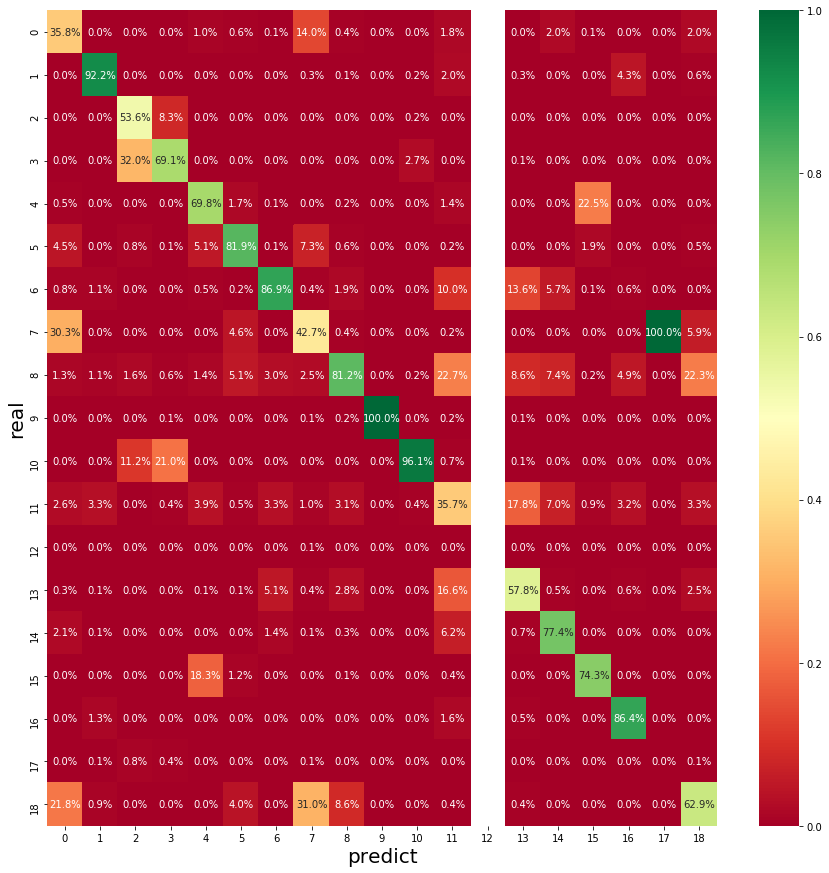

In [62]:
plt.figure(figsize =(15,15))
sns.heatmap(cm_result/np.sum(cm_result),annot = True, cmap ='RdYlGn',fmt='.1%')
plt.ylabel("real",fontsize=20)
plt.xlabel("predict",fontsize=20)
plt.show()

# REAL

In [63]:
train_ds = lgb.Dataset(train_X, label = train_y, categorical_feature=['fiberID'])

In [64]:
lgmb_model = lgb.train(params, train_ds,num_boost_round= 2000, verbose_eval=100)

C:\Users\starl\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


In [65]:
train_X.shape

(199991, 21)

In [66]:
test_X.shape

(10009, 21)

In [67]:
y_pred = lgmb_model.predict(test_X)

In [68]:
y_pred

array([[4.19043761e-05, 2.62228621e-04, 7.35085131e-05, ...,
        9.76341891e-05, 4.43091117e-06, 3.06003893e-04],
       [4.46367274e-04, 1.07480779e-03, 1.89992585e-05, ...,
        5.30003809e-05, 6.48034488e-06, 1.97359208e-03],
       [1.19185021e-04, 6.45605571e-05, 3.44668324e-06, ...,
        8.22278134e-06, 1.34464154e-06, 1.74256234e-04],
       ...,
       [1.90486959e-03, 4.07903642e-04, 2.20201700e-05, ...,
        5.25337058e-05, 6.71692256e-06, 3.14896790e-02],
       [1.86719490e-04, 1.13258853e-04, 1.20305021e-06, ...,
        2.87012705e-06, 1.07779749e-06, 6.02503953e-03],
       [1.49264791e-03, 1.08125171e-04, 5.83700267e-06, ...,
        1.39253866e-05, 1.78051533e-06, 5.73382727e-04]])

In [69]:
submission = pd.DataFrame(data=y_pred, columns=sample_submission_df.columns, index=sample_submission_df.index)
submission.to_csv('./submisson/submission.csv', index=True)